In [1]:
import pandas
import numpy as np
#import import_ipynb
#import FeatureStore

In [2]:
#Параметры
Period = 40
ProbThreshold = 0.7
clf = None
mu = 0
sigma = 0
InitialCapital = 100000.0

In [3]:
# Загружаем данные для бэктеста
backtest = pandas.read_csv('SPY2019_ForTest.csv', delimiter=';')
backtest['Date'] = pandas.to_datetime(backtest['Date'], format = '%d.%m.%Y')
date = backtest.iloc[:, 0]
Y = backtest.iloc[:,1]
X = backtest.iloc[:, 2:46]

In [4]:
# Загружаем данные по ETF
stock_df = pandas.read_csv("SPY2019.csv")
# фильтруем
stock_df = stock_df[stock_df['Date'] >= '2017-03-30']
stock_df = stock_df[stock_df['Date'] <= '2019-09-18']
stock_df.reset_index(drop = True, inplace = True)
stock_df['Date'] = pandas.to_datetime(stock_df['Date'])

In [5]:
from sklearn.preprocessing import StandardScaler

#https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
def scaleDataFrame(dataframe, debugPrint = False):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(dataframe)
    dataframe = pandas.DataFrame(scaled_features, index=dataframe.index, columns=dataframe.columns)
    
    #check
    if debugPrint == True:
        for column in dataframe:
            print("[%s] mean = %.4f, variance = %.4f" % 
                  (column, dataframe[column].mean(), dataframe[column].var()))
    
    return dataframe, scaler.mean_, scaler.scale_

In [9]:
# тренируем классификатор
from sklearn.neural_network import MLPClassifier

def initStrategy(period):
    #global sigma
    #global mu
    #global clf
    #trying Alpha = 0.100000, period = 40, function = relu
    alpha = 0.1
    activation = 'relu'
    
    data = pandas.read_csv('SPY2019_ForTrain.csv', delimiter=';')
    date = data.iloc[:, 0]
    y_train = data.iloc[:,1]
    X_train = data.iloc[:, 2:46]
    
    #print(y_train[:10])
    y_train = pandas.Series(np.where(y_train.values >= 0, 1, 0),
          y_train.index)
    #print(y_train[:10])
    #print(y_train)
    #X_train = FeatureStore.getTrainDataset(period)
    #y_train = FeatureStore.getTrainTarget(period)
    
    X_train, sigma, mu = scaleDataFrame(X_train, debugPrint = False)
    #print(X_train)
    
    clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation=activation, solver='sgd', 
                    alpha = alpha, max_iter = 10000, random_state=241)
    
    #trying 100-tree forest, period = 40, function = gini
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, criterion = 'gini', random_state=241) 
    #trying C = 0.100000, period 40, kernel = linear
    from sklearn import svm
    clf = svm.SVC(C = 0.1, kernel = 'linear', gamma='auto', probability = True, random_state=241)
    
    clf.fit(X_train, y_train)
    return clf, mu, sigma

clf, mu, sigma = initStrategy(Period)

In [10]:
# центрируем/нормируем бэктестовые данные точно так же, как тренировочную выробку
X = ((X-mu) / sigma)
# получаем прогнозы классификатора в виде вероятностей
probs = clf.predict_proba(X)

In [11]:
Prob0 = probs[:, 0]
Prob1 = probs[:, 1]

Prob0[Prob0.size - Period:Prob0.size] = 0
Prob1[Prob0.size - Period:Prob0.size] = 0
#print(np.where(Prob0 >= ProbThreshold, -1, 0)[0:10])
#print(np.where(Prob1 >= ProbThreshold, 1, 0)[0:10])

ShortDeals = np.where(Prob0 >= ProbThreshold, -1, 0)
LongDeals = np.where(Prob1 >= ProbThreshold, 1, 0)
Position = ShortDeals + LongDeals
CumulativePosition = np.zeros(Position.size)
for index in range(0, Position.size):
    CumulativePosition[index] = np.sum(Position[max(index - Period,0) : index + 1])
    if (index < -1):
        print("index %d pos %d" % (index, CumulativePosition[index]))
Result = (pandas.DataFrame({"Date": date, "CumulativePosition": CumulativePosition}))

Result["Profit"] = 0.0
for index in range(1, Result.index.size):
    #print(index)
    pnl = Result["Profit"]
    close = stock_df["Adj Close"]
    #print(close)
    pnl[index] = pnl[index - 1] + 100 * CumulativePosition[index] * (close[index] - close[index - 1])
#print(PnL)

Result['Capital'] = Result['Profit'] + InitialCapital

Result.to_csv("test.csv", index=False, sep=";")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Total capital')

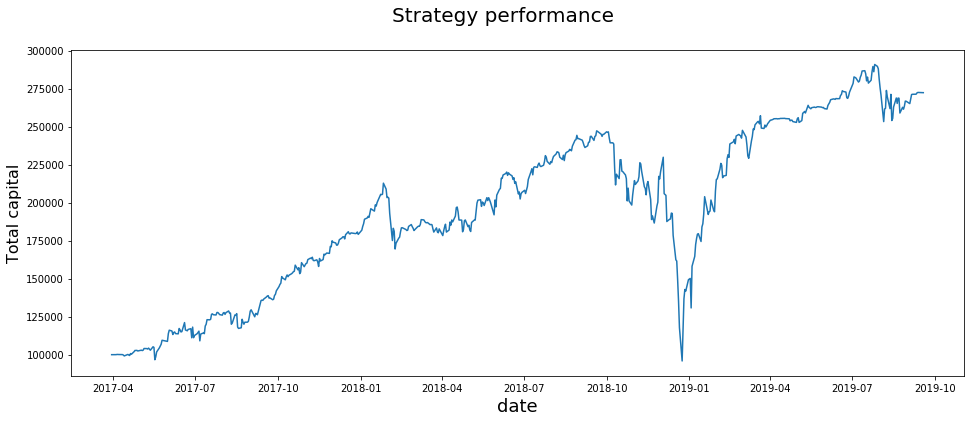

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot(df['Date'], df['Profit'])
fig = plt.figure(figsize=(16,6))
plt.plot(Result['Date'], Result['Capital'])
fig.suptitle('Strategy performance', fontsize=20)
plt.xlabel('date', fontsize=18)
plt.ylabel('Total capital', fontsize=16)

#ax = plt.plot(Result['Date'], Result['Capital'])
#ax.xlabel('xlabel', fontsize=18)
#df['Date'][20:50]
#data

In [13]:
# Считаем CAGR
firstIndex = 0
lastIndex = Result.index.size -1
#print(lastIndex)
date2 = Result['Date'][lastIndex]
date1 = Result['Date'][firstIndex]
td = date2 - date1
years = td / np.timedelta64(1, 'Y')
EndValue = Result['Profit'][lastIndex]
BeginValue = Result['Profit'][firstIndex]
BeginValue += InitialCapital
EndValue += InitialCapital
cagr = (EndValue / BeginValue) ** (1/years) - 1
print(cagr)
#print(BeginValue, EndValue, years)

0.5004686054693239


In [14]:
# Волатильность стратегии
#volatility formula may be wrong, taken from here https://stackoverflow.com/a/43285442
volatility = Result['Capital'].pct_change(1).std()*(252**0.5)
print(volatility)

0.48734609137408225


In [15]:
# Средняя прибыль на сделку
DealCount = abs(ShortDeals.sum()) + LongDeals.sum()
AverageProfit = (EndValue - BeginValue) / DealCount
lastPrice = stock_df['Adj Close'][lastIndex]
AverageProfit /= lastPrice * 100
print(AverageProfit)

0.011278715538217705


In [16]:
# Sharpe Ratio
#https://towardsdatascience.com/calculating-sharpe-ratio-with-python-755dcb346805
daily_return = Result['Capital'].pct_change(1)
#print(Result['Capital'].pct_change(1))
#print(daily_return.mean())
#print(daily_return.std())
SR = daily_return.mean() / daily_return.std()
SR_1Y = (252**0.5) * SR
print("Sharpe Ratio =", SR)

Sharpe Ratio = 0.06708937704208547


In [17]:
# correlation to S&P 500
np.corrcoef(Result['Capital'], stock_df['Adj Close'])

array([[1.        , 0.98679082],
       [0.98679082, 1.        ]])